In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Data"
npz_files = [f for f in os.listdir(dataset_dir) if f.endswith('.npz')]

In [3]:
X = list()
y = list()

for file in npz_files:
    file_path = os.path.join(dataset_dir, file)
    data = np.load(file_path)

    eit_data = data['eit']
    torque_value = data['torque']

    eit_data_flat = eit_data.reshape(-1)  # Flatten the 16x16 frames into a single vector

    X.append(eit_data_flat)
    y.append(torque_value)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} samples, each with {X.shape[1]} features")

Loaded 18635 samples, each with 256 features


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train)
X_test_reg = scaler.transform(X_test)

X_train_cnn = X_train_reg.reshape(-1, 16, 16, 1)  # Reshape to (samples, height, width, channels)
X_test_cnn = X_test_reg.reshape(-1, 16, 16, 1)

# Define the CNN model

In [5]:
# Define the CNN model
model_cnn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(16, 16, 1)),  # Input shape (16, 16, 1)
    
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(256, activation='relu'),  
    
    tf.keras.layers.Dense(1)  # Output layer (regression)
])


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 664.3242 - val_loss: 414.0182
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 336.3836 - val_loss: 264.7753
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 243.2490 - val_loss: 247.4985
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 210.8616 - val_loss: 219.1462
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 191.8984 - val_loss: 189.0443
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 173.9399 - val_loss: 179.1679
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 163.5179 - val_loss: 184.3841
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 160.0560 - val_loss: 158.4322
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 137.8775 - val_loss: 147.7696
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 135.8917 - val_loss: 166.2858
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 130.9515 - val_loss: 144.4069
Ep

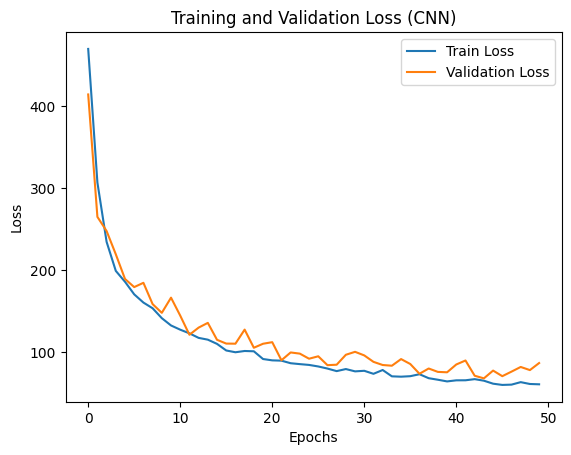

In [6]:
# Compile the model
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='mean_squared_error')

# Train the model
history_cnn = model_cnn.fit(X_train_cnn, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Evaluate the model
y_pred_cnn = model_cnn.predict(X_test_cnn)

# Calculate metrics
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)

# Print the metrics
print(f"CNN Model - MSE: {mse_cnn:.4f}, MAE: {mae_cnn:.4f}")

# Plot the training history
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss (CNN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

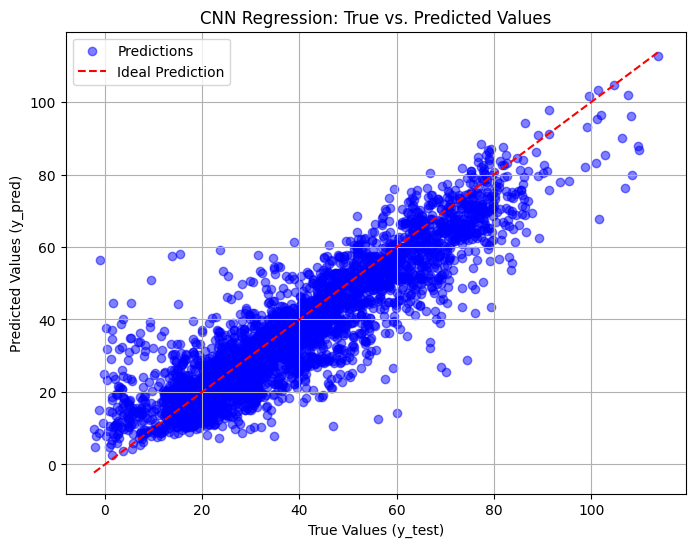

In [10]:
y_pred_cnn = y_pred_cnn.flatten()

# Scatter plot: True vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_cnn, alpha=0.5, color='blue', label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', label="Ideal Prediction")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("CNN Regression: True vs. Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

## Relative Error

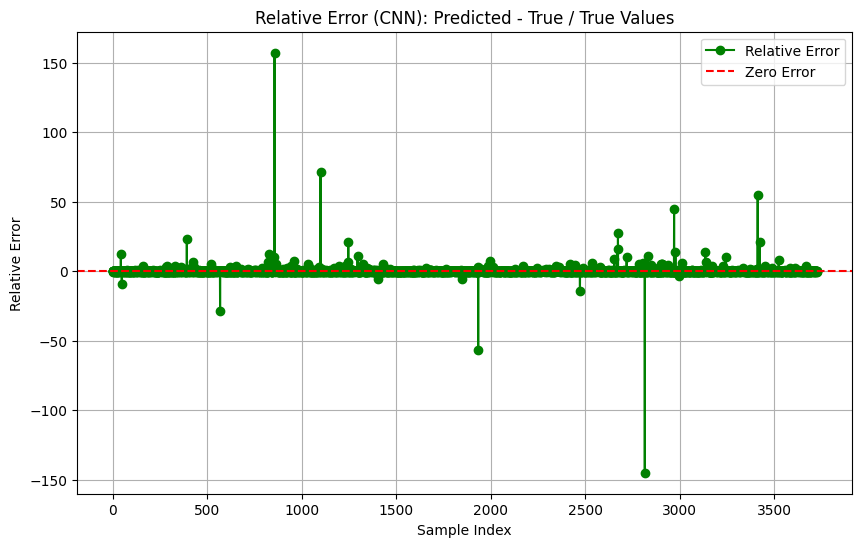

In [11]:
plt.figure(figsize=(10, 6))

# Compute the relative error (Prediction - True) / True
relative_error = (y_pred_cnn - y_test) / y_test

plt.plot(relative_error, label="Relative Error", marker='o', color='green', linestyle='solid')
plt.axhline(0, color='red', linestyle='dashed', label="Zero Error")
plt.xlabel("Sample Index")
plt.ylabel("Relative Error")
plt.title("Relative Error (CNN): Predicted - True / True Values")
plt.legend()
plt.grid(True)
plt.show()